This jupyter notebook has been created by Bright Uchenna Oparaji. For any information about the scripts, please contact me via e-mail: u.oparaji@liv.ac.uk or uchenna.oparaji@yahoo.co.uk. Enjoy the tutorial!  

# Introduction
The aim of this tutorial is to build a model and forcast the expected queue time on the Epic cluster at Zenotech adopting supervised machine learning method. Given the fact that the training data provided to train the model is strongly time dependent (i.e. time series data), a Long Short Term Memory (LSTM) model has been adopted. LSTM are units of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. LSTM networks are well-suited to perfrom classification, regression and make predictions based on time series data, since there can be lags of unknown duration between important events in a time series.   


## Training Data Set 
First, to manipulate and visualise the data set provided by Zenotech, several python libraries are imported:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Now let's load the training data using the pandas library:

In [2]:
dataset_train = pd.read_csv('TrainingData.csv')

Now let's have a look at the data:

In [3]:
dataset_train

,Partition,QOS,ReqNodes,ReqCPUS,NNodes,Timelimit,Anon Account,Job Duration,Queue Time
0,highmem,normal,20,320,20,240,46,240.47,2880.000
1,highmem,normal,20,320,20,240,46,240.00,2880.000
2,K80,normal,8,16,8,720,46,720.03,0.017
3,standard,normal,30,60,30,1440,46,17.13,0.017
4,standard,normal,1,24,1,10000000,46,1.37,0.000
5,small,normal,1,24,1,10000000,46,1.80,0.000
6,K80,normal,8,16,8,720,46,0.18,0.000
7,K80,normal,8,16,8,720,46,36.68,0.000
8,standard,normal,12,24,12,2880,46,39.45,0.000
9,standard,normal,30,60,30,1440,46,6.88,0.000


We can see some categorical features in the data set (i.e. 'Partition' & 'QOS'). From previous analyses, I realized that these categorical features do not improve the model perfromance but worsten it's perfromance, so I have decided to ommit them. Hence, the new training data set is:  

In [4]:
training_set = dataset_train.iloc[:, 2:9].values

I have also decided to remove Anon Account feature because it dosen't improve the model:

In [5]:
training_set=np.delete(training_set, 4, 1)

Now, we create a new variable to store the new training data:

In [6]:
training_set_new = training_set

Here, rather than solve a regression problem of mapping the features to the queue time, we try to classify the data by grouping the queue time into various classes (i.e. < 5 min, < 30 min, < 60 min, < 120 min, < 240 min, < 600 min, > 600 min), then, train the model to classify the data:

In [7]:
for i in range(len(training_set_new)):
    if training_set[i, 5] < 5:
        training_set_new[i, 5] = 1 # first class
    elif training_set[i, 5] < 30:
        training_set_new[i, 5] = 2 # second class
    elif training_set[i, 5] < 60:
        training_set_new[i, 5] = 3 # third class
    elif training_set[i, 5] < 120:
        training_set_new[i, 5] = 4 # fourth class
    elif training_set[i, 5] < 240:
        training_set_new[i, 5] = 5 # fifth class
    elif training_set[i, 5] < 600:
        training_set_new[i, 5] = 6 # sixth class
    elif training_set[i, 5] > 600:
        training_set_new[i, 5] = 7 # seventh class

## Feature Scaling
Feature scaling is a method used to standardize the range of independent variables or features of data. Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. For example, the majority of classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance. Now let's rescale the data to fall in the range of [0, 1]. This will enable the model learn better. Note that the labels to predict have been left in their originnal format. The other features have been rescaled:

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set_new[:,0:5])

Now, we apply one-hot encoding scheme to the queue time in order to transform the queue time classes from 1-7 to 0-6:

In [9]:
from sklearn.preprocessing import LabelEncoder
training_set_new_class = training_set_new[:,5]
training_set_new_class_reshape = training_set_new_class.reshape(training_set_new_class.size, 1)
training_set_scaled = np.append(training_set_scaled, training_set_new_class_reshape, axis=1)
labelencoder_Re_ID = LabelEncoder()
training_set_scaled[:, 5] = labelencoder_Re_ID.fit_transform(training_set_scaled[:, 5])

Here, we split the training data into two parts (i.e. 80% and 20%). The first part (80%) contains the data which will be used to train the model while the second part (20%) will be used to test the model's perfromance in terms of predicting future queue times:  

In [10]:
training_size = int(np.ceil(training_set_scaled[:,0].size*0.8))
lag = 2 # number of realizations in the past the model looks back in order to predict the future
training_set_final = training_set_scaled[0:training_size,:]
test_set_final = training_set_scaled[training_size+1-lag:-1,:]

Now let's reshape the training and test data so they can be accepted as inputs in keras.

In [11]:
X_train = []
y_train = []
for i in range(lag, training_set_final[:,0].size):
    X_train.append(training_set_final[i-lag:i, 0:6])
    y_train.append(training_set_final[i, 5])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping training set
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))

In [12]:
X_test = []
y_test = []
for j in range(lag, test_set_final[:,0].size):
    X_test.append(test_set_final[j-lag:j, 0:6])
    y_test.append(test_set_final[j, 5])
X_test, y_test = np.array(X_test), np.array(y_test)
# Reshaping test set
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

Now we have the training and test data ready let's build a simple LSTM model in keras.

In [13]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

C:\Users\BRIGHT\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [35]:
classifier = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
classifier.add(LSTM(units = 3, input_shape = (X_train.shape[1], 6)))
classifier.add(Dropout(0.2))
# Adding the output layer with a softmax activation function for multi classification
classifier.add(Dense(7, activation='softmax'))
# Compiling the RNN
classifier.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3)                 120       
_________________________________________________________________
dropout_2 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 28        
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________


## Softmax function
A softmax function, is a generalization of the logistic function that "squashes" a $K$-dimensional vector $\displaystyle \mathbf {z}$  of arbitrary real values to a $K$-dimensional vector $\sigma (\mathbf {z} )$ of real values, where each entry is in the range (0, 1], and all the entries add up to 1. Note that the target is a ($K$-1)-dimensional space: one dimension has been lost.

Now we train the model:

In [36]:
classifier.fit(X_train, y_train, epochs = 5, batch_size=32)

Epoch 1/5
168894/168894 [==============================] - 22s 128us/step - loss: 0.8904 - acc: 0.7323
Epoch 2/5
168894/168894 [==============================] - 17s 102us/step - loss: 0.7669 - acc: 0.7628
Epoch 3/5
168894/168894 [==============================] - 17s 99us/step - loss: 0.7574 - acc: 0.7768
Epoch 4/5
168894/168894 [==============================] - 17s 99us/step - loss: 0.7535 - acc: 0.7783
Epoch 5/5
168894/168894 [==============================] - 17s 100us/step - loss: 0.7492 - acc: 0.7788


Here we save the model:

In [38]:
from keras.models import load_model
classifier.save('classifier.h5')  # creates a HDF5 file 
del classifier  # deletes the existing model

load the model

In [40]:
classifier = load_model('classifier.h5')

Here, we make a prediction with the test set (i.e. remaining 20% data):

In [41]:
predicted_test = classifier.predict(X_test)

Note that the variable 'predicted_test' contains an 2-d array, where the columns in the array represents the classes and the rows represents the probability of occurance of a particular class. Our job here is to identify the classes with the highest probability as the class predicted by the model. To achieve that, we create a function that returns the class with the highest probability:   

In [17]:
def compute_class_index(predicted_test):
    output_list = []
    for i in range(predicted_test.shape[0]):
        max_prediction_index = np.argmax(predicted_test[i, :])
        output_list.append(max_prediction_index)
    return output_list
index = compute_class_index(predicted_test)

Here we plot the first 500 predictions from the model:

(0, 6)

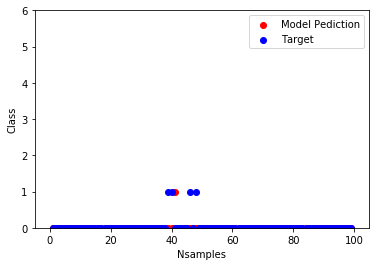

In [18]:
sample_index = list(range(1, predicted_test.shape[0]+1))
f1 = plt.figure()
plt.scatter(sample_index[0:99], index[0:99], color = 'red', label = 'Model Pediction')
plt.scatter(sample_index[0:99], y_test[0:99], color = 'blue', label = 'Target')
plt.xlabel('Nsamples')
plt.ylabel('Class')
plt.legend()
axes = f1.gca()
axes.set_ylim([0, 6])

(0, 6)

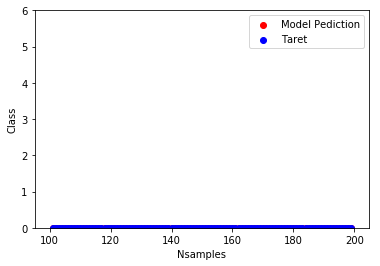

In [19]:
f2 = plt.figure()
plt.scatter(sample_index[100:199], index[100:199], color = 'red', label = 'Model Pediction')
plt.scatter(sample_index[100:199], y_test[100:199], color = 'blue', label = 'Taret')
plt.xlabel('Nsamples')
plt.ylabel('Class')
plt.legend()
axes = f2.gca()
axes.set_ylim([0, 6])

(0, 6)

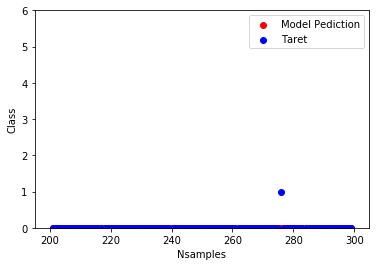

In [20]:
f3 = plt.figure()
plt.scatter(sample_index[200:299], index[200:299], color = 'red', label = 'Model Pediction')
plt.scatter(sample_index[200:299], y_test[200:299], color = 'blue', label = 'Taret')
plt.xlabel('Nsamples')
plt.ylabel('Class')
plt.legend()
axes = f3.gca()
axes.set_ylim([0, 6])

(0, 6)

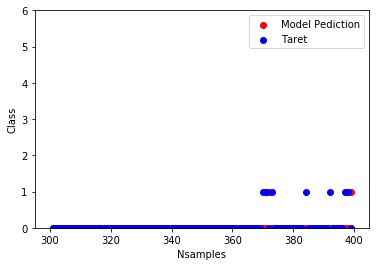

In [21]:
f4 = plt.figure()
plt.scatter(sample_index[300:399], index[300:399], color = 'red', label = 'Model Pediction')
plt.scatter(sample_index[300:399], y_test[300:399], color = 'blue', label = 'Taret')
plt.xlabel('Nsamples')
plt.ylabel('Class')
plt.legend()
axes = f4.gca()
axes.set_ylim([0, 6])

(0, 6)

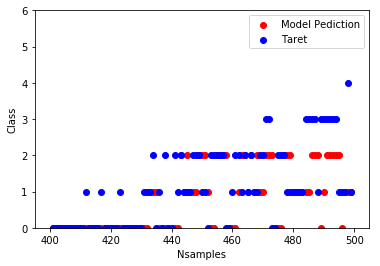

In [22]:
f5 = plt.figure()
plt.scatter(sample_index[400:499], index[400:499], color = 'red', label = 'Model Pediction')
plt.scatter(sample_index[400:499], y_test[400:499], color = 'blue', label = 'Taret')
plt.xlabel('Nsamples')
plt.ylabel('Class')
plt.legend()
axes = f5.gca()
axes.set_ylim([0, 6])

The model seems to be doing ok for the first 500 test sample. Now let's compute the reliability of the model (i.e. the number of times the predicted value matches the target). Here, I create a function that computes the model reliability: 

In [23]:
def compute_model_reliability(index, y_test):
    out_list = []
    for z in range(predicted_test.shape[0]):
        if index[z] == int(y_test[z]):
            indicator = 1
        else:
            indicator = 0
        out_list.append(indicator)
    model_reliability = np.sum(out_list)/len(out_list)
    return model_reliability

In [24]:
model_reliability = compute_model_reliability(index, y_test)
print(model_reliability)

0.8698514957011914


88% model reliability is actually very good.

Now, let's check the perfromance of the model on the training set

In [25]:
predicted_train = classifier.predict(X_train)

In [26]:
index_train = compute_class_index(predicted_train)

In [27]:
model_reliability_train = compute_model_reliability(index_train, y_train)
print(model_reliability_train)

0.8072523151985979


# Conclusion
In summary, a time series model that predicts the queue times of jobs submitted on the Epic cluster has been constructed based on two years data provided by Zenotech. The model constructed consist of one LSTM layer which takes into account the time dependency in the training data. The results...    